In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read in the BTC data
data = pd.read_csv('btc_in_sample_data.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp', inplace=True)

# Parameters
period = 20  
multiplier = 2 
x_days = 5 
stop_loss = 0.2  # Stop loss (20%)

# Compute Bollinger Bands
data['SMA'] = data['Close'].rolling(window=period).mean()
data['STD'] = data['Close'].rolling(window=period).std()
data['Upper Band'] = data['SMA'] + (multiplier * data['STD'])
data['Lower Band'] = data['SMA'] - (multiplier * data['STD'])

# Drop rows with NaN values
data.dropna(inplace=True)
# Add Buy Signal and Sell Signal
data['Buy Signal'] = data['Close'] > data['Upper Band']
data['Sell Signal'] = data['Close'] < data['Lower Band']


In [3]:
# Initialize the variables to track strategy performance
capital = 10000  # Starting capital in USD
position = 0  # Current position (0 = no position, 1 = long)
entry_price = 0  # Price when the position is opened
exit_price = 0  # Price when the position is closed
trade_results = []  # List to store results of each trade
equity_curve = [capital]  # Equity curve starting with initial capital
number_of_trades = 0
trade_dates = []

# Buy and hold returns
buy_and_hold_returns = data['Close'].pct_change()
buy_and_hold_cumulative_returns = (np.cumprod(1 + buy_and_hold_returns) - 1) * 100 
buy_and_hold_drawdown = (data['Close'] / data['Close'].cummax() - 1) * 100 
buy_and_hold_max_drawdown = min(buy_and_hold_drawdown)

In [4]:
# Iterate through the data to simulate the strategy
for i in range(period, len(data)):
    current_date = data.index[i]
    if position == 0 and data['Buy Signal'].iloc[i]:  # Buy Signal
        position = 1
        entry_price = data['Close'].iloc[i]
        entry_date = current_date
        stop_loss_price = entry_price * (1 - stop_loss)  # Set the stop loss
        number_of_trades += 1
    elif position == 1:
        # Check if the stop loss is hit
        if data['Close'].iloc[i] <= stop_loss_price:
            exit_price = stop_loss_price
            exit_date = current_date
            trade_results.append((entry_price, exit_price, 'Stop Loss'))
            trade_dates.append((entry_date, exit_date, 'Stop loss'))
            position = 0
            equity_curve.append(equity_curve[-1] * (1 + (exit_price - entry_price) / entry_price))
        # Check if we've held for x days
        elif (current_date - entry_date).days >= x_days:
            exit_price = data['Close'].iloc[i]
            exit_date = current_date
            trade_results.append((entry_price, exit_price, f'Exit after {x_days} bars'))
            trade_dates.append((entry_date, exit_date, f'Exit after {x_days} bars'))
            position = 0
            equity_curve.append(equity_curve[-1] * (1 + (exit_price - entry_price) / entry_price))

# Calculate performance metrics
returns = np.diff(equity_curve) / equity_curve[:-1] 
cumulative_returns = (np.cumprod(1 + returns) - 1) * 100  # Cumulative returns
total_return = cumulative_returns[-1]   # Total return in percentage

# Convert equity curve to a numpy array for calculation
equity_curve = np.array(equity_curve)
# Calculate drawdowns
peak = np.maximum.accumulate(equity_curve)  # Tracks the maximum equity level at each point
drawdowns = (equity_curve - peak) / peak  # Drawdown at each point
max_drawdown = drawdowns.min() * 100  # Maximum drawdown in percentage

# Sharpe Ratio (assuming daily risk-free rate of 0)
sharpe_ratio = np.mean(returns) / np.std(returns) if np.std(returns) != 0 else 0

# Winrate
wins = sum(1 for entry, exit, reason in trade_results if exit > entry)
winrate = wins / number_of_trades if number_of_trades > 0 else 0

# Profit Factor
gross_profit = sum(exit - entry for entry, exit, reason in trade_results if exit > entry)
gross_loss = sum(entry - exit for entry, exit, reason in trade_results if exit < entry)
profit_factor = gross_profit / gross_loss if gross_loss != 0 else float('inf')

# Exposure time percentage (time spent in position divided by total time)
exposure_time = (x_days * number_of_trades) / len(data) * 100

# Print the results
print(f"Strategy Final Return: {total_return:.2f}%")
print(f"Strategy Max Drawdown: {max_drawdown:.2f}%")
print(f"Win Rate: {winrate:.2%}")
print(f"Profit Factor: {profit_factor:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Number of Trades: {number_of_trades}")
print(f"Buy & Hold Final Return: {buy_and_hold_cumulative_returns.iloc[-1]:.2f}%")
print(f"Buy and Hold Max Drawdown: {buy_and_hold_max_drawdown:.2f}%")
print(f"Exposure Time: {exposure_time:.2f}%")

Strategy Final Return: 235.25%
Strategy Max Drawdown: -70.55%
Win Rate: 50.33%
Profit Factor: 1.09
Sharpe Ratio: 0.09
Number of Trades: 304
Buy & Hold Final Return: 286.05%
Buy and Hold Max Drawdown: -83.91%
Exposure Time: 3.24%


In [5]:
equity_curve

array([ 10000.        ,  10148.41462434,  10385.33712779,   9557.68999162,
         7646.1519933 ,   8117.42196456,   9363.85852527,   9130.17016974,
        10245.6004179 ,  11445.1055914 ,  11400.3592612 ,  12262.92117529,
        14805.80049352,  13025.66077712,  15208.79957201,  15557.23883713,
        18918.424842  ,  23815.02782568,  29520.69076601,  28084.21324632,
        25417.50532933,  30217.73237657,  24174.18590125,  21817.12338785,
        22862.34725141,  18289.87780113,  20140.11410527,  24271.49505895,
        21570.49960217,  22398.75528922,  22806.49876031,  19989.82502428,
        21088.32837111,  18839.83856207,  18222.40600424,  20766.28196093,
        21227.50282835,  22748.05282366,  22511.19756425,  23020.99119482,
        20505.72527971,  19403.44690355,  17081.61915858,  17101.93610428,
        17264.68174193,  16289.85027955,  14974.86091342,  14271.17053882,
        15063.61459995,  14567.02071649,  17355.42071649,  19107.34968574,
        17816.49687553,  

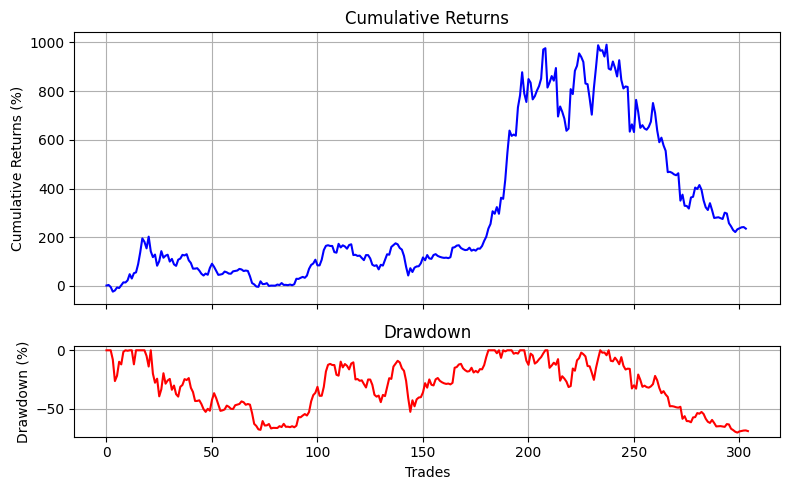

In [6]:
# Plot the equity curve and drawdown
# Convert drawdowns to percentages for better visualization
drawdown_percentage = drawdowns * 100

# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# Plot Equity Curve
axs[0].plot(cumulative_returns, label='Cumulative Returns', color='blue')
axs[0].set_title('Cumulative Returns')
axs[0].set_ylabel('Cumulative Returns (%)')
axs[0].grid()

# Plot Drawdown
axs[1].plot(drawdown_percentage, label='Drawdown', color='red')
axs[1].set_title('Drawdown')
axs[1].set_ylabel('Drawdown (%)')
axs[1].set_xlabel('Trades')
axs[1].grid()

# Adjust layout and display
plt.tight_layout()
plt.show()

### Some checkings

In [7]:
trade_dates

[(Timestamp('2017-08-23 10:00:00'),
  Timestamp('2017-08-28 10:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-08-29 12:00:00'),
  Timestamp('2017-09-03 12:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-09-06 15:00:00'),
  Timestamp('2017-09-11 15:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-09-12 05:00:00'),
  Timestamp('2017-09-14 16:00:00'),
  'Stop loss'),
 (Timestamp('2017-09-15 14:00:00'),
  Timestamp('2017-09-20 14:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-09-23 04:00:00'),
  Timestamp('2017-09-28 04:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-09-30 05:00:00'),
  Timestamp('2017-10-05 05:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-10-05 12:00:00'),
  Timestamp('2017-10-10 12:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-10-10 17:00:00'),
  Timestamp('2017-10-15 17:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-10-19 01:00:00'),
  Timestamp('2017-10-24 01:00:00'),
  'Exit after 5 bars'),
 (Timestamp('2017-10-25 23:00:00'),
  Timestamp(

In [8]:
trade_results

[(np.float64(4228.02), np.float64(4290.77), 'Exit after 5 bars'),
 (np.float64(4408.08), np.float64(4510.99), 'Exit after 5 bars'),
 (np.float64(4619.43), np.float64(4251.29), 'Exit after 5 bars'),
 (np.float64(4325.0), np.float64(3460.0), 'Stop Loss'),
 (np.float64(3780.0), np.float64(4012.98), 'Exit after 5 bars'),
 (np.float64(3677.35), np.float64(4242.01), 'Exit after 5 bars'),
 (np.float64(4256.22), np.float64(4150.0), 'Exit after 5 bars'),
 (np.float64(4312.28), np.float64(4839.11), 'Exit after 5 bars'),
 (np.float64(4937.0), np.float64(5515.0), 'Exit after 5 bars'),
 (np.float64(5621.99), np.float64(5600.01), 'Exit after 5 bars'),
 (np.float64(5689.99), np.float64(6120.5), 'Exit after 5 bars'),
 (np.float64(6223.33), np.float64(7513.82), 'Exit after 5 bars'),
 (np.float64(7536.06), np.float64(6629.98), 'Exit after 5 bars'),
 (np.float64(6598.99), np.float64(7705.0), 'Exit after 5 bars'),
 (np.float64(7944.0), np.float64(8126.0), 'Exit after 5 bars'),
 (np.float64(8280.89), np.fl

In [9]:
buy_and_hold_returns = data['Close'].pct_change()
buy_and_hold_returns

timestamp
2017-08-17 23:00:00         NaN
2017-08-18 00:00:00    0.000338
2017-08-18 01:00:00   -0.010017
2017-08-18 02:00:00    0.005656
2017-08-18 03:00:00    0.005811
                         ...   
2022-12-31 19:00:00   -0.000461
2022-12-31 20:00:00   -0.000093
2022-12-31 21:00:00   -0.001226
2022-12-31 22:00:00   -0.001660
2022-12-31 23:00:00    0.001307
Name: Close, Length: 46962, dtype: float64

In [10]:
buy_and_hold_cumulative_returns = (1 + buy_and_hold_returns).cumprod() - 1
buy_and_hold_cumulative_returns

timestamp
2017-08-17 23:00:00         NaN
2017-08-18 00:00:00    0.000338
2017-08-18 01:00:00   -0.009682
2017-08-18 02:00:00   -0.004082
2017-08-18 03:00:00    0.001706
                         ...   
2022-12-31 19:00:00    2.866938
2022-12-31 20:00:00    2.866579
2022-12-31 21:00:00    2.861837
2022-12-31 22:00:00    2.855426
2022-12-31 23:00:00    2.860465
Name: Close, Length: 46962, dtype: float64

In [11]:
buy_and_hold_cumulative_returns = np.cumprod(1 + buy_and_hold_returns) - 1 
buy_and_hold_cumulative_returns

timestamp
2017-08-17 23:00:00         NaN
2017-08-18 00:00:00    0.000338
2017-08-18 01:00:00   -0.009682
2017-08-18 02:00:00   -0.004082
2017-08-18 03:00:00    0.001706
                         ...   
2022-12-31 19:00:00    2.866938
2022-12-31 20:00:00    2.866579
2022-12-31 21:00:00    2.861837
2022-12-31 22:00:00    2.855426
2022-12-31 23:00:00    2.860465
Name: Close, Length: 46962, dtype: float64

In [12]:
data['Close']/data['Close'].cummax() -1 

timestamp
2017-08-17 23:00:00    0.000000
2017-08-18 00:00:00    0.000000
2017-08-18 01:00:00   -0.010017
2017-08-18 02:00:00   -0.004418
2017-08-18 03:00:00    0.000000
                         ...   
2022-12-31 19:00:00   -0.758571
2022-12-31 20:00:00   -0.758594
2022-12-31 21:00:00   -0.758890
2022-12-31 22:00:00   -0.759290
2022-12-31 23:00:00   -0.758976
Name: Close, Length: 46962, dtype: float64